# Metabolic Modeling in Microbial Community Engineering: A Case Study on Marine Coastal Oil Spills

Oil spills are among the most devastating environmental disasters, posing significant threats to marine ecosystems. The aftermath of such spills sees a surge in microbial communities capable of degrading the hydrocarbons present in the oil. These communities form intricate trophic networks, with various species playing specific roles in the degradation process.

In a recent study titled ["Harnessing the Potential of Native Microbial Communities for Bioremediation of Oil Spills in the Iberian Peninsula NW Coast"](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full), it was observed that oil spills lead to a drastic decrease in microbial diversity, with the enriched communities being dominated by hydrocarbon-degrading genera such as Alcanivorax, Pseudomonas, Acinetobacter, and others. These microbes possess the genetic potential to degrade a range of aromatic compounds, including toluene, a representative compound commonly found in oil spills.

Another study, ["Disentangling the microbial genomic traits associated with aromatic hydrocarbon degradation in a jet fuel-contaminated aquifer"](https://www.researchsquare.com/article/rs-3200599/v1), delves deeper into the metabolic pathways associated with hydrocarbon degradation. It proposes a metabolic model based on genome-centered analysis, functional predictions, and flux balance analysis (FBA) to describe the degradation process in jet-fuel-contaminated sites.

## Purpose of this Notebook

This Jupyter Notebook aims to utilize a community genome-scale metabolic model, incorporating the species identified in the aforementioned studies, to investigate the trophic network that emerges post a marine coastal oil spill. By focusing on toluene as a representative compound, we will explore how it is taken up and processed by the microbial community.

Through this exercise, we hope to:

1. **Understand the Dynamics**: Gain insights into the interactions and dynamics of microbial communities in response to oil spills.
2. **Highlight the Role of Metabolic Modeling**: Showcase the potential of metabolic modeling as a powerful tool in microbial community engineering.
3. **Provide a Framework**: Offer a structured approach for researchers and practitioners aiming to harness microbial communities for bioremediation purposes.

## The community and the environment

We will model a community of bacteria that are known to be involved in the degradation of toluene. The involved genera are:

- *Alcanivorax*
- *Pseudomonas*
- *Acinetobacter*
- *Marinobacter*
- *Thalassospira*
- *Pseudomonas*

As representatives of carbon sources that are commonly found in surface waters, we will use:

- *Glycogen*, which is the main storage polymer in cyanobacteria, and as much as [100-fold more abundant](https://ami-journals.onlinelibrary.wiley.com/doi/full/10.1111/1462-2920.14302) than other phytoplankton exudates, such as free monosaccharides or amino acids. 
- *Glycinebetaine*, which is [highly abundant](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9321204/) in marine environments.
- *D-Xylulose*, as representative of the degradation of microalgal polysaccharides.

Finally, as a representative of the oil spill, we will use *Toluene*, which is a major toxic component of crude oil.

In [1]:
import pandas as pd

medium = pd.read_csv('data/oilspill_medium.tsv', sep='\t', header=None)
medium.columns = ["reaction", "flux"]
# medium.set_index('reaction', inplace=True)
medium.head()

,reaction,flux
0,EX_ca2_m,0.00252
1,EX_cl_m,10.00001
2,EX_co2_m,10.00001
3,EX_cobalt2_m,10.00001
4,EX_cu2_m,10.00001


In [2]:
# from pathlib import Path
# import cobra

# # gem_dir = Path("/home/robaina/Databases/micom_carveme_genus/data")
# gem_dir = Path("models/")
# models = {}

# for file in gem_dir.glob("*.json"):
#     model_name = file.stem
#     model = cobra.io.load_json_model(file)
#     models[model_name] = model

## Building the Community Model

To construct the community model, we will assemble individual models that correspond to the diverse genera of microbes identified in our studies. We employ the `build` workflow from the micom toolbox, which integrates these individual models into a unified community model. The output is a pickle file that encapsulates the complete community model for subsequent analysis.

The use of individual models is crucial; each represents the metabolic capabilities of a single species. By combining them, we account for the metabolic diversity present in the community. This approach mirrors the collaborative efforts in microbial communities, where each organism contributes to the community's resilience and functionality.

If you prefer to proceed directly to analysis, you may use the pre-built community model available in the `data` folder as pickle file.

In [3]:
import pandas as pd

taxo_df = pd.read_csv("data/micom_database.csv", sep=",", index_col=None)
taxo_df

,sample_id,id,abundance,file
0,oilspill,Acinetobacter_sp,100,models/Acinetobacter.json
1,oilspill,Alcanivorax_sp,100,models/Alcanivorax.json
2,oilspill,Alteromonas_sp,100,models/Alteromonas.json
3,oilspill,Flavobacterium_sp,100,models/Flavobacterium.json
4,oilspill,Marinobacter_sp,100,models/Marinobacter.json
5,oilspill,Oleibacter_sp,100,models/Oleibacter.json
6,oilspill,Polaribacter_sp,100,models/Polaribacter.json
7,oilspill,Pseudomonas_sp,100,models/Pseudomonas.json
8,oilspill,Rhodococcus_sp,100,models/Rhodococcus.json
9,oilspill,Thalassospira_sp,100,models/Thalassospira.json


In [4]:
# from micom.workflows import build

# manifest = build(taxonomy=taxo_df, model_db=None, out_folder="results/micom", cutoff=1e-2, threads=14 , solver="gurobi")
# manifest

In [5]:
from micom import load_pickle

cgem = load_pickle("results/micom/oilspill.pickle")
cgem

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-05
Read LP format model from file /tmp/tmpt91hqcsj.lp
Reading time = 0.36 seconds
: 15669 rows, 49781 columns, 209395 nonzeros


Name,oilspill
Memory address,7f09a7d93cd0
Number of metabolites,15658
Number of reactions,24890
Number of genes,11823
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"C_c__Acinetobacter_sp, C_p__Acinetobacter_sp, C_e__Acinetobacter_sp, m, C_c__Alcanivorax_sp, C_e__Alcanivorax_sp, C_p__Alcanivorax_sp, C_c__Alteromonas_sp, C_p__Alteromonas_sp, C_e__Alteromonas_sp, C_e__Flavobacterium_sp, C_p__Flavobacterium_sp, C_c__Flavobacterium_sp, C_c__Marinobacter_sp, C_p__Marinobacter_sp, C_e__Marinobacter_sp, C_c__Oleibacter_sp, C_p__Oleibacter_sp, C_e__Oleibacter_sp, C_c__Polaribacter_sp, C_p__Polaribacter_sp, C_e__Polaribacter_sp, C_c__Pseudomonas_sp, C_p__Pseudomonas_sp, C_e__Pseudomonas_sp, C_c__Rhodococcus_sp, C_p__Rhodococcus_sp, C_e__Rhodococcus_sp, C_c__Thalassospira_sp, C_p__Thalassospira_sp, C_e__Thalassospira_sp"


In [6]:
model_medium = {k: v for k, v in medium.set_index("reaction")["flux"].items() if k in cgem.exchanges}
cgem.medium = model_medium
cgem.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Acinetobacter_sp,0.1,0.003065,2904,1747
Alcanivorax_sp,0.1,0.000000,2005,1329
Alteromonas_sp,0.1,0.000000,2308,1509
Flavobacterium_sp,0.1,4.996805,2868,1679
Marinobacter_sp,0.1,0.000000,2761,1654
...,...,...,...,...
Polaribacter_sp,0.1,0.000000,1973,1311
Pseudomonas_sp,0.1,0.000000,3277,1869
Rhodococcus_sp,0.1,0.000000,2639,1548


In [7]:
# sol = cgem.cooperative_tradeoff(fraction=0.5)
# sol

## Exploring community metabolite exchange fluxes

We will now use the community model to explore the metabolic interactions between the different species. To this end, we will use micom's `grow` workflow, which will simulate the growth of the community on the different carbon sources in the provided medium (including the pollutant toluene). To do so, the workflow will use the cooperative growth algorithm that we saw before, with a tradeoff parameter (between community and individual growth rates) of 0.5. The workflow will output an exchanges dataframe containing the fluxes of all metabolites exchanged between the different species. We will use this dataframe to visualize the metabolic interactions between the different species.

In [8]:
# from micom.workflows import grow

# res = grow(manifest, model_folder="results/micom/", medium=new_medium, tradeoff=0.5, threads=12)
# res.exchanges.to_csv("results/micom/exchanges.tsv", sep="\t")

## Identifying key metabolites and species in the community through sensitivity analysis

In the intricate web of microbial communities, the concept of `elasticity` offers a quantitative lens through which we can discern the relative responsiveness of metabolic reactions to changes in metabolite concentrations. Elasticity, in this context, is akin to a measure of metabolic sensitivity—it gauges how a small perturbation in a metabolite's level influences the velocity of an enzyme-catalyzed reaction. By examining the elasticities within a community's metabolic network, we can pinpoint key metabolites that act as critical control points, effectively dictating the flux of biochemical pathways. Similarly, we can identify influential community members whose metabolic activities are pivotal in shaping the community dynamics. These species often have a disproportionate impact on the community's overall metabolic landscape, making them prime targets for further analysis. Through elasticity analysis, we not only gain insight into the robustness and stability of the community but also uncover potential levers for modulating its behavior, paving the way for targeted interventions and engineered symbioses.

In [9]:
# from micom.elasticity import elasticities


# eps = elasticities(cgem, fraction=0.5, reactions=cgem.exchanges)
# eps.head()

The results table from the elasticity analysis provides insights into how the rates of specific reactions within a microbial community are influenced by changes in metabolite concentrations. The 'Reaction' column lists the biochemical reactions, while 'Taxon' indicates the associated microbe or environmental medium. 'Effector' refers to the metabolite impacting the reaction rate, and 'Direction' shows whether the reaction rate increases, decreases, or remains unchanged with effector concentration changes. The 'Elasticity' value quantifies this sensitivity, with higher values indicating greater responsiveness.

### Evaluating the effects of different taxa on toluene degradation

With the previusly calculated elasticities, we can assess the influence that increasing the abundance of specific taxa has on the community's uptake of toluene. By examining the elasticity values associated with toluene uptake, we can identify which microorganisms have a significant impact on this process. A positive elasticity value suggests that a higher abundance of the taxon leads to increased toluene uptake, while a negative value indicates the opposite. This investigation is crucial for understanding the role of each species in toluene metabolism and for potentially guiding the engineering of microbial communities for bioremediation or bioaugmentation purposes.

In [10]:
import pandas as pd

# Load the data
df = pd.read_csv('results/micom/elasticity_analysis.tsv', sep='\t')

# Filter rows related to toluene intake and taxa abundance
toluene_intake_effects = df[(df['reaction'] == 'EX_tol_m') & (df['type'] == 'abundance')]

# Print the results
toluene_intake_effects

,Unnamed: 0,reaction,taxon,effector,direction,elasticity,type
8203,8203,EX_tol_m,medium,Acinetobacter_sp,reverse,0.290787,abundance
8624,8624,EX_tol_m,medium,Alcanivorax_sp,reverse,3.861581,abundance
9045,9045,EX_tol_m,medium,Alteromonas_sp,reverse,-5.203019,abundance
9466,9466,EX_tol_m,medium,Flavobacterium_sp,reverse,0.608322,abundance
9887,9887,EX_tol_m,medium,Marinobacter_sp,reverse,1.360368,abundance
10308,10308,EX_tol_m,medium,Oleibacter_sp,reverse,1.766614,abundance
10729,10729,EX_tol_m,medium,Polaribacter_sp,reverse,0.907652,abundance
11150,11150,EX_tol_m,medium,Pseudomonas_sp,reverse,4.808788,abundance
11571,11571,EX_tol_m,medium,Rhodococcus_sp,reverse,0.998081,abundance
11992,11992,EX_tol_m,medium,Thalassospira_sp,reverse,3.510812,abundance


The results from the toluene intake effects analysis show how an increase in the abundance of each different taxon in the community affects the uptake of toluene by `Acinetobacter`. By default, the uptake of a compound in an exchange reaction corresponds to the 'reverse' direction (thus negative flux values). On the other hand, a positive elasticity value indicates that there is direct relationship between the abundance of the taxon and the uptake of toluene (an increase in abundance is followed by an increase in toluene uptake), while a negative elasticity indicates an inverse relationship.

In this case, we can see that an increase in the abundance of `Acinetobacter` is followed by an increase in t he uptake of `toluene`. This is expected, as `Acinetobacter` is the only species in the community that can directly uptake toluene. However, we can also see that an increase in the abundances of almost all of the other taxa in the community also leads to an increase in toluene uptake, particularly marked in the case of `Pseudomonas`, `Alcanivorax`, and `Thalassospira`. This is because these taxa produce metabolites that are taken up by `Acinetobacter` and which probably directly or indirectly facilitate toluene degradation by supporting the growth of `Acinetobacter`(we will delve into this later). Interestingly, `Alteromonas` show a negative elasticity value, meaning an increase in its abundance corresponds to a decrease in the update of toluene by `Acinetobacter`. This could be due to competition for resources (like intermediate metabolites excreted by the community) between these two taxa. 

As we can see, conducting a sensitivity or elasticity analysis can be very informative. With a simple run we have identify taxa that either support or hampers the uptake of our target environmental pollutant. Armed with this information, we could design intervention strategies to optimize community uptake of toluene, either by directly reducing a particular taxon (e.g. through a taxon-specific virus) or by manipulating environmental conditions so they are less favorable to the competing taxon.


In [11]:
import pandas as pd


exchanges_df = pd.read_csv('results/micom/exchanges.tsv', sep='\t')
acinetobacter_imports = exchanges_df[(exchanges_df['taxon'] == 'Acinetobacter_sp') & (exchanges_df['direction'] == 'import')]
producers = exchanges_df[(exchanges_df['metabolite'].isin(acinetobacter_imports['metabolite'])) & (exchanges_df['direction'] == 'export')]
merged_df = pd.merge(acinetobacter_imports, producers, on='metabolite', suffixes=('_import', '_export'))
result_df = merged_df[['metabolite', 'flux_import', 'taxon_export', 'flux_export']]
result_df

,metabolite,flux_import,taxon_export,flux_export
0,pro__L_e,-0.039335,Alcanivorax_sp,0.170832
1,pro__L_e,-0.039335,Thalassospira_sp,0.049446
2,h2o2_e,-17.523853,Pseudomonas_sp,90.656167
3,h2o2_e,-17.523853,Alcanivorax_sp,54.020134
4,h2o2_e,-17.523853,Polaribacter_sp,50.000000
5,h2o2_e,-17.523853,Oleibacter_sp,68.031043
6,gly_e,-8.948290,Alcanivorax_sp,124.392349
7,gly_e,-8.948290,Thalassospira_sp,22.532202
8,gly_e,-8.948290,Marinobacter_sp,62.926482
9,pacald_e,-55.537896,Flavobacterium_sp,25.857210


## Computing community knockouts

We will now use micom's `community_knockout` workflow to compute the effect of knocking out each species in the community on the community's growth rate. The workflow will output a dataframe containing the growth rate of the community when each species is knocked out. We will use this dataframe to visualize the effect of knocking out each species on the community's growth rate.

In [12]:
# ko = cgem.knockout_taxa(fraction=1.0)
# ko.index.name = "KO"
# ko[ko.abs() < 1e-6] = 0
# ko.to_csv('results/micom/ko_analysis.tsv', sep='\t')
ko = pd.read_csv('results/micom/ko_analysis.tsv', sep='\t', index_col="KO")
ko[ko.abs() < 1e-6] = 0
ko

,Acinetobacter_sp,Alcanivorax_sp,Alteromonas_sp,Flavobacterium_sp,Marinobacter_sp,Oleibacter_sp,Polaribacter_sp,Pseudomonas_sp,Rhodococcus_sp,Thalassospira_sp
KO,,,,,,,,,,
Acinetobacter_sp,-0.360375,0.003259,0.100787,-3.018540,0.610582,0.031211,0.722506,1.371553,0.539045,0.000040
Alcanivorax_sp,-0.025059,0.000000,0.000968,-3.260084,0.701765,0.000524,0.133094,1.210635,1.238047,0.000030
Alteromonas_sp,0.056031,0.000195,0.000000,-3.198191,0.613752,0.000613,0.741162,1.236142,0.549630,-0.000099
Flavobacterium_sp,-0.350292,0.000000,0.000000,-4.629305,4.237854,0.000000,0.748874,0.000008,0.000016,-0.010027
Marinobacter_sp,-0.350439,0.000000,0.000005,-4.628379,0.000000,0.000000,0.000015,4.875496,0.000200,-0.009899
Oleibacter_sp,0.160883,0.000000,0.000000,-0.161620,0.000000,0.000000,-0.000223,0.000000,0.000000,-0.000540
Polaribacter_sp,0.026947,0.000219,0.000336,-2.981642,0.785853,0.000089,-0.000223,1.442904,0.725292,-0.000020
Pseudomonas_sp,-0.360043,0.000033,0.000270,-0.633728,0.288617,0.000021,0.202783,0.000000,0.502669,-0.000629
Rhodococcus_sp,0.175157,0.021808,0.001983,-3.176452,0.900620,0.010247,0.742048,1.324609,0.000000,0.000030


## Plot ecological interaction graph

Let's us visualize the community KO analysis with an ecological interaction graph. In this graph, blue edges represent a positive or cooperative effect between taxa (i.e., an increase in abundance of one taxon is followed by an increase in the growth rate of the other taxon), while red edges represent a negative or competitive effect (i.e., an increase in abundance of one taxon is followed by a decrease in the growth rate of the other taxon). The thickness of the edges is proportional to the magnitude of the effect.

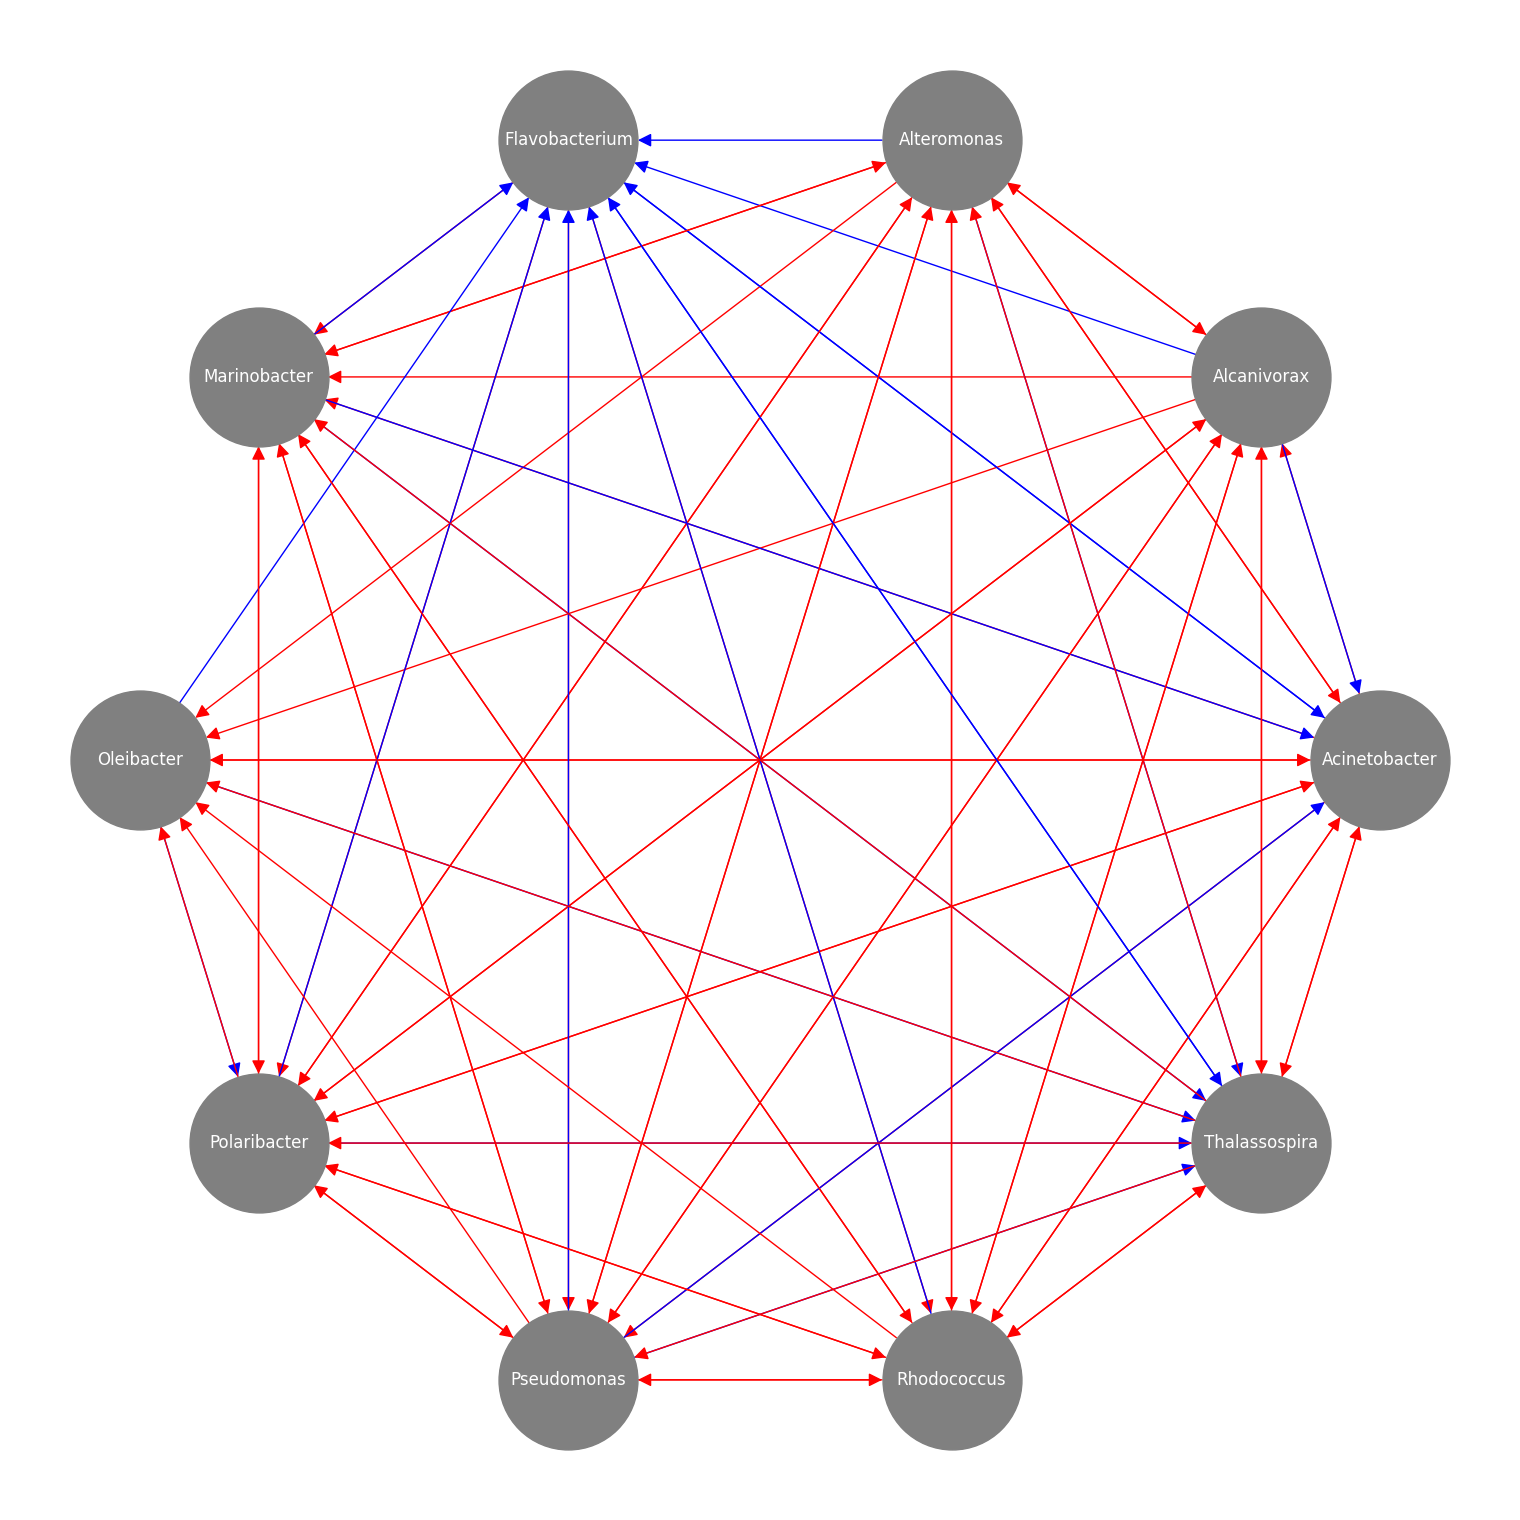

In [13]:
from src.helper_functions import plot_ecological_interactions


plot_ecological_interactions(ko)

## Plot interaction graph

In [14]:
import pandas as pd

exchanges_df = pd.read_csv("results/micom/exchanges.tsv", sep="\t")
export_df = exchanges_df[exchanges_df["direction"] == "export"]
import_df = exchanges_df[exchanges_df["direction"] == "import"]
merged_df = pd.merge(import_df, export_df, on="metabolite", how="outer")
final_df = merged_df[["sample_id_x", "taxon_x", "taxon_y", "metabolite"]]
final_df.columns = ["sample_id", "donor", "receiver", "compound"]
final_df.loc[final_df["donor"].isnull(), "donor"] = None
# Replace glycogen ID
final_df.loc[:, "compound"] = final_df["compound"].str.replace("glycogen1500_m", "glycog_m")

medium_sources = [
    m.replace("_m", "")
    for m in final_df[final_df["donor"] == "medium"]["compound"].unique()
]

/tmp/ipykernel_46420/329164551.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[final_df["donor"].isnull(), "donor"] = None
/tmp/ipykernel_46420/329164551.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, "compound"] = final_df["compound"].str.replace("glycogen1500_m", "glycog_m")


In [15]:
import networkx as nx
from src.helper_functions import generate_bipartite_graph


exchanges_file_path = "results/micom/exchanges.tsv"
hidden_taxa = [
    "medium", "Alcanivorax", "Oleibacter",
    "Flavobacterium","Rhodococcus", "Polaribacter",
    ]
hidden_metabolites = ['h', 'h2', 'btn', 'ca2', 'cl', 'co2', 'cu2', 'fe2', 'fe3', 'k', 'no2', 'no3', 'so4', 'thm', 'zn2', 'pi', 'h2o', 'o2', 'cobalt2', 'nh4', 'hco3', 'mg2', 'mn2']

hidden_metabolites_extended = []
for metabolite in hidden_metabolites:
    hidden_metabolites_extended.append(metabolite + "_m")
    hidden_metabolites_extended.append(metabolite + "_e")

bipartite_graph = generate_bipartite_graph(
    exchanges_file_path,
    hide_taxa=hidden_taxa,
    hide_metabolites=hidden_metabolites,
    keep_metabolites=["bz"],
    flux_cutoff=0.0,
    target_taxon="Acinetobacter",
    environmental_carbon_sources=medium_sources,
    relabel_nodes={"glycogen1500": "glycog"},
    output_graph="results/micom/bipartite_graph.json",
    )

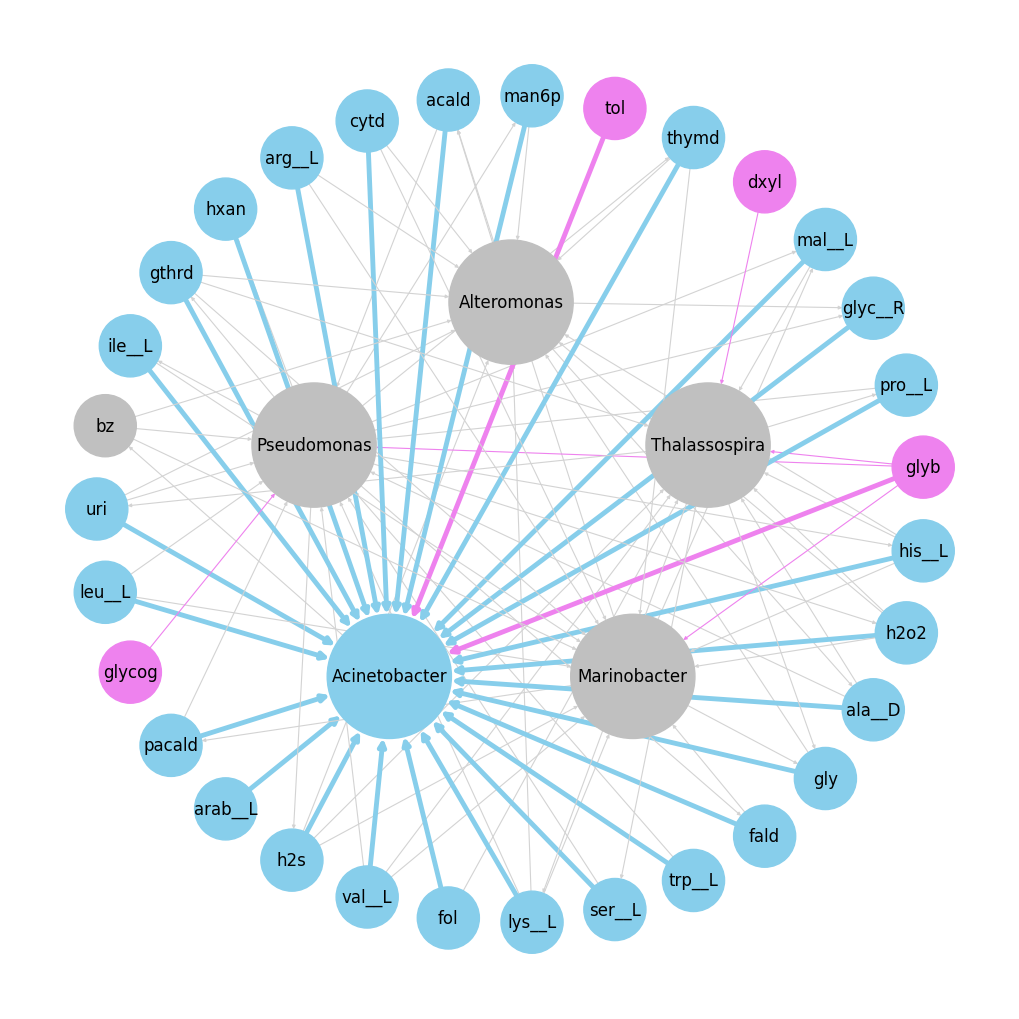

In [16]:
from src.helper_functions import plot_trophic_interactions


color_carbon_sources = 'violet'
color_acinetobacter = 'skyblue'
color_other_edges = 'lightgrey'
color_other_nodes = 'silver'
large_node_size = 8000
small_node_size = 2000
target_taxon = 'Acinetobacter'
target_compound = 'tol'



plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=medium_sources,
    target_taxon='Acinetobacter',
    color_carbon_sources='violet',
    color_acinetobacter='skyblue',
    color_other_edges='lightgrey',
    color_other_nodes='silver',
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_acinetobacter=3.5,
    edge_width_other=0.8,
    arrow_size_acinetobacter=10,
    arrow_size_other=5,
)

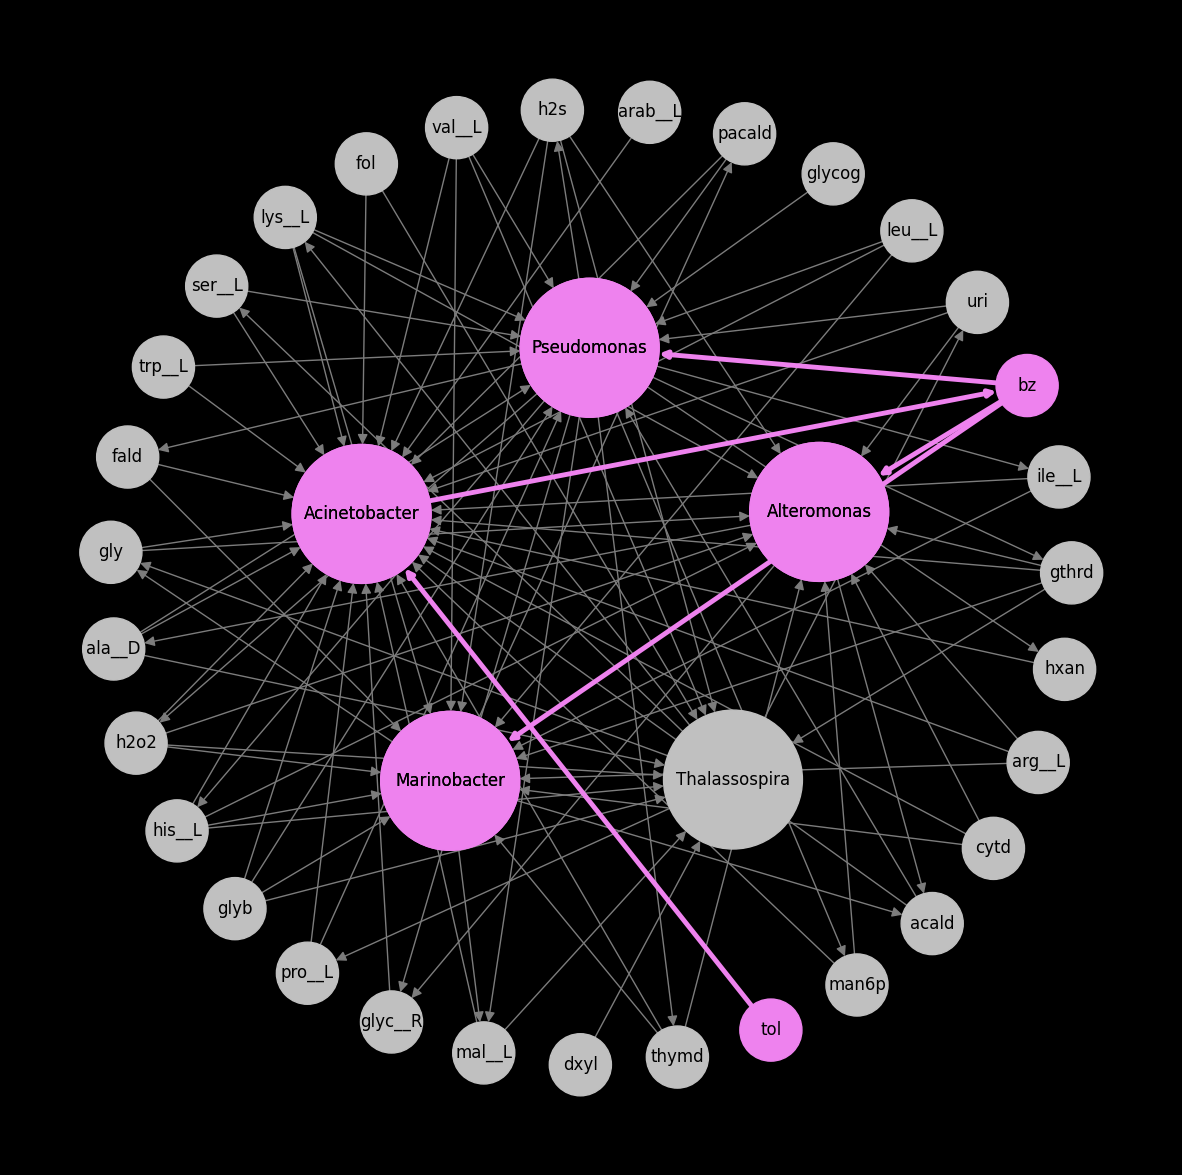

In [40]:
import matplotlib.pyplot as plt
import networkx as nx
import random



def plot_trophic_interactions(
    bipartite_graph,
    environmental_carbon_sources,
    highlight_compounds=None,
    target_taxon="Acinetobacter",
    target_compound="tol",
    color_oil_nodes="violet",
    color_other_edges="lightgrey",
    color_other_nodes="silver",
    large_node_size=6000,
    small_node_size=1000,
    edge_width_target_taxon=3.5,
    edge_width_other=0.8,
    arrow_size_target_taxon=10,
    arrow_size_other=5,
    figsize=(15, 15),
    seed: int = None,
):
    if highlight_compounds is None:
        highlight_compounds = []

    if seed is None:
        seed = random.randint(0, 100)

    taxon_nodes_connected_to_highlight = [
        n
        for compound in highlight_compounds
        for n in bipartite_graph.neighbors(compound)
        if bipartite_graph.nodes[n]["bipartite"] == 0
    ]

    medium_donors = environmental_carbon_sources
    direct_nodes = list(bipartite_graph.neighbors(target_compound)) + [target_compound]
    indirect_nodes = [
        neighbor
        for node in direct_nodes
        for neighbor in bipartite_graph.neighbors(node)
    ]
    indirect_nodes_extended = [
        neighbor
        for node in indirect_nodes
        for neighbor in bipartite_graph.neighbors(node)
    ]
    target_taxon_compounds = [
        n
        for n in bipartite_graph.to_undirected().neighbors(target_taxon)
        if bipartite_graph.nodes[n]["bipartite"] == 1
    ]
    species_connected_to_target_taxon_compounds = [
        n
        for compound in target_taxon_compounds
        for n in bipartite_graph.neighbors(compound)
        if bipartite_graph.nodes[n]["bipartite"] == 0
    ]
    subgraph_nodes = (
        direct_nodes
        + indirect_nodes
        + indirect_nodes_extended
        + target_taxon_compounds
        + species_connected_to_target_taxon_compounds
    )
    subgraph = bipartite_graph.subgraph(subgraph_nodes)
    medium_donor_edges = [
        (u, v)
        for u, v in bipartite_graph.edges()
        if u in medium_donors and bipartite_graph.nodes[v]["bipartite"] == 0
    ]
    extended_subgraph = nx.DiGraph(subgraph)
    extended_subgraph.add_edges_from(medium_donor_edges)

    for node in extended_subgraph.nodes():
        if "bipartite" not in extended_subgraph.nodes[node]:
            extended_subgraph.nodes[node]["bipartite"] = 1

    shell_layout_extended_subgraph = nx.shell_layout(
        extended_subgraph,
        [
            set(
                n for n, d in extended_subgraph.nodes(data=True) if d["bipartite"] == 0
            ),
            set(
                n for n, d in extended_subgraph.nodes(data=True) if d["bipartite"] == 1
            ),
        ],
        rotate=seed,
    )

    fig, ax = plt.subplots(figsize=figsize)

    non_highlight_edges = [(u, v) for u, v in extended_subgraph.edges() if u not in highlight_compounds and v not in highlight_compounds]
    non_highlight_subgraph = extended_subgraph.edge_subgraph(non_highlight_edges)

    highlight_edges = [(u, v) for u, v in extended_subgraph.edges() if u in highlight_compounds or v in highlight_compounds]
    highlight_subgraph = extended_subgraph.edge_subgraph(highlight_edges)

    nx.draw(
            non_highlight_subgraph,
            shell_layout_extended_subgraph,
            with_labels=True,
            node_size=[
                large_node_size if bipartite == 0 else small_node_size
                for bipartite in nx.get_node_attributes(
                    non_highlight_subgraph, "bipartite"
                ).values()
            ],
            node_color=[
                color_oil_nodes
                if node in highlight_compounds or node == target_taxon or node in taxon_nodes_connected_to_highlight
                else color_other_nodes
                for node, bipartite in nx.get_node_attributes(
                    non_highlight_subgraph, "bipartite"
                ).items()
            ],
            edge_color=color_other_edges,
            arrowsize=arrow_size_other,
            width=edge_width_other,
        )

    nx.draw(
        highlight_subgraph,
        shell_layout_extended_subgraph,
        with_labels=True,
        node_size=[
            large_node_size if bipartite == 0 else small_node_size
            for bipartite in nx.get_node_attributes(
                highlight_subgraph, "bipartite"
            ).values()
        ],
        node_color=[
            color_oil_nodes
            if node in highlight_compounds or node == target_taxon or node in taxon_nodes_connected_to_highlight
            else color_other_nodes
            for node, bipartite in nx.get_node_attributes(
                highlight_subgraph, "bipartite"
            ).items()
        ],
        edge_color=color_oil_nodes,
        arrowsize=arrow_size_target_taxon,
        width=edge_width_target_taxon,
    )

    nx.draw_networkx_edge_labels(
        extended_subgraph,
        shell_layout_extended_subgraph,
        edge_labels=nx.get_edge_attributes(extended_subgraph, "weight"),
    )

    ax.set_facecolor('black')
    ax.axis('off')
    fig.set_facecolor('black')
    plt.show()



plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=medium_sources,
    highlight_compounds=["tol", "bz"],
    target_taxon='Acinetobacter',
    color_oil_nodes='violet',
    color_other_edges='#7c7c7c',
    color_other_nodes='silver',
    large_node_size=10000,
    small_node_size=2000,
    edge_width_target_taxon=3.5,
    edge_width_other=1.0,
    arrow_size_target_taxon=10,
    arrow_size_other=15,
    figsize=(15, 15),
)

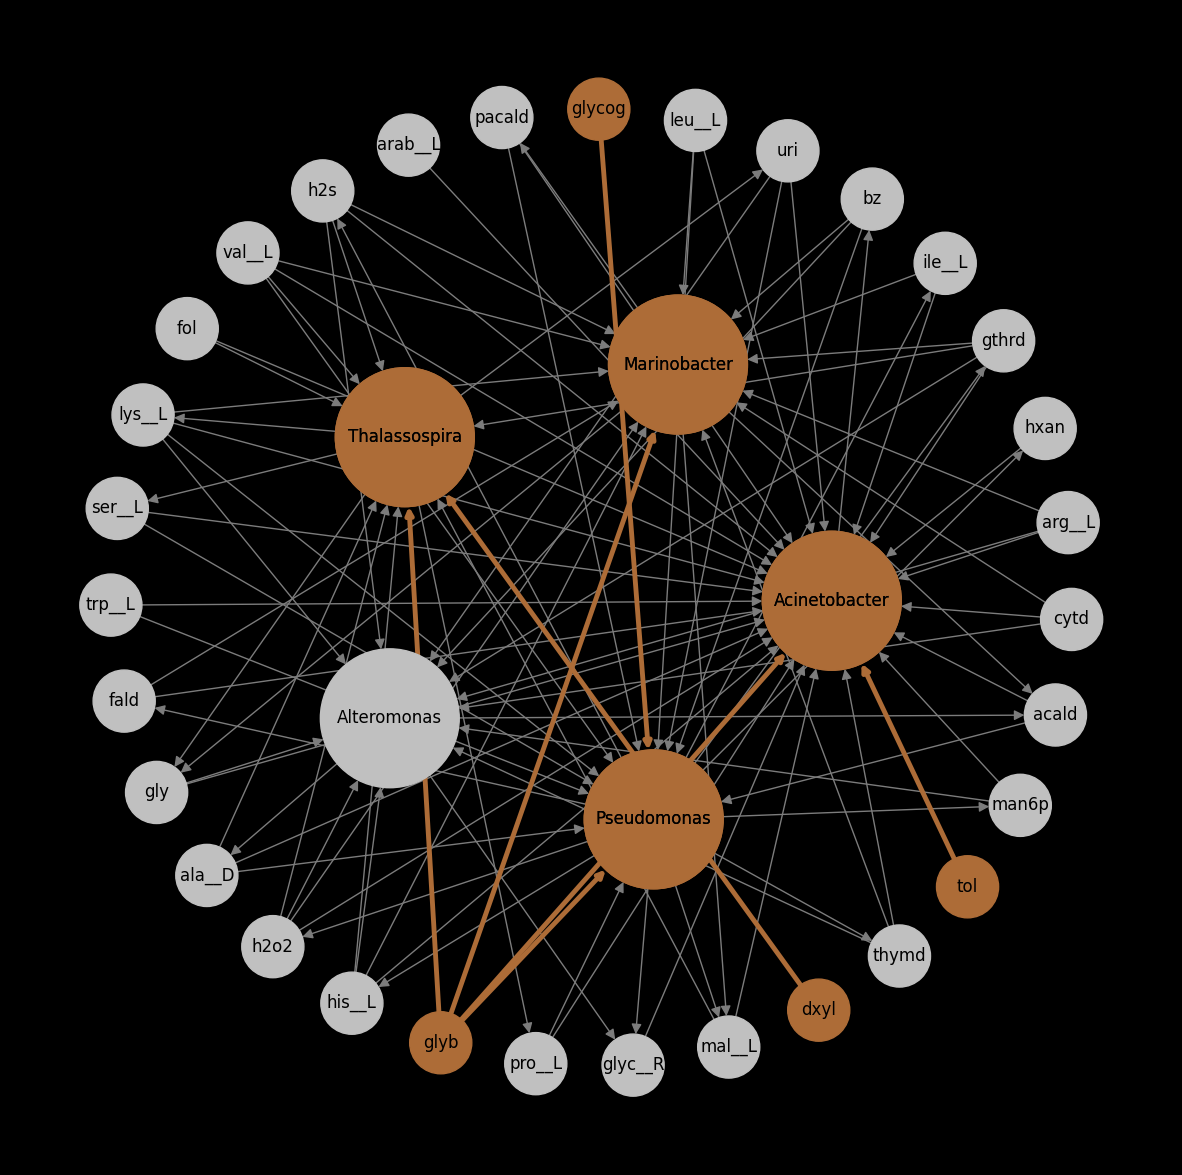

In [35]:
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=medium_sources,
    highlight_compounds=["glycog", "dxyl", "glyb", "tol"],
    target_taxon='Acinetobacter',
    color_oil_nodes='#ad6c37',
    color_other_edges='#7c7c7c',
    color_other_nodes='silver',
    large_node_size=10000,
    small_node_size=2000,
    edge_width_target_taxon=3.5,
    edge_width_other=1.0,
    arrow_size_target_taxon=10,
    arrow_size_other=15,
    figsize=(15, 15),
    seed=None
)